# Bài tập trên lớp về Spam Filtering
Trong bài tập này, chúng ta sẽ sử dụng các công cụ mạnh mẽ có sẵn như pandas/sklearn để thực hiện công việc phân biệt giữa mail spam và mail thường qua thông tin của chính email đó.

## Download dữ liệu
Dữ liệu được tải về bằng gdown vào cùng folder với file hiện tại. Sau khi tải, chúng ta unzip dữ liệu nhận được.

In [1]:
!gdown https://drive.google.com/uc?id=1bTJKchSInd3IgLs41b1_-Gd-T36a_pal -O spam_data.zip

Downloading...
From: https://drive.google.com/uc?id=1bTJKchSInd3IgLs41b1_-Gd-T36a_pal
To: e:\01. VinBigData\06. NLP_VIN\spam_data.zip

  0%|          | 0.00/1.95M [00:00<?, ?B/s]
 27%|██▋       | 524k/1.95M [00:00<00:00, 1.71MB/s]
 80%|████████  | 1.57M/1.95M [00:00<00:00, 4.18MB/s]
100%|██████████| 1.95M/1.95M [00:00<00:00, 4.21MB/s]


In [3]:
# !unzip -f spam_data.zip

## Sử dụng pandas để lưu trữ
Pandas là thư viện thường được sử dụng để cất giữ dữ liệu được sử dụng trong quá trình thực hiện các phương pháp học máy, với các chức năng phù hợp với dữ liệu lớn và hiệu năng cao. Chúng ta đọc dữ liệu của file đã được unzip vào một DataFrame.

In [13]:
import pandas as pd
data_loc = "spam_ham_dataset.csv"

spam_data = pd.read_csv(data_loc, header=0)
spam_data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


**Học viên in ra 5 mail spam và 5 mail ham đầu tiên xuất hiện trong dữ liệu ở block bên dưới:** 

In [14]:
# CODE HERE

spam_data_ham = spam_data[spam_data['label'] == 'ham']
spam_data_spam = spam_data[spam_data['label'] == 'spam']

spam_data_ham.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
5,2949,ham,Subject: ehronline web address change\r\nthis ...,0


In [15]:
spam_data_spam.head()

,Unnamed: 0,label,text,label_num
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
7,4185,spam,Subject: looking for medication ? we ` re the ...,1
10,4922,spam,Subject: vocable % rnd - word asceticism\r\nvc...,1
11,3799,spam,Subject: report 01405 !\r\nwffur attion brom e...,1
13,3948,spam,Subject: vic . odin n ^ ow\r\nberne hotbox car...,1


## Data preprocessing
Như chúng ta có thể thấy, dữ liệu hiện tại đang chứa ký tự xuống dòng \r\n của Window và có thể dẫn đến ảnh hưởng xấu trong quá trình xây dựng chương trình. Để đơn giản hóa, chúng ta thay nó bằng dấu cách. Các bạn có thể ứng dụng phương án của pandas để thực hiện thêm các ý tưởng bản thân (v.d xóa chữ Subject: từ đầu, nhặt ra dòng đầu tiên, etc.)

**Học viên sử dụng hàm `.apply` của pandas để format lại trường text, sử dụng hàm lambda tên `format_fn`:**

In [16]:
format_fn = lambda x: x.lower().replace("subject:", "").strip()
drop_fn = lambda x: x.replace("\r\n", " ")
drop_space_first = lambda x: x[1:] if x[0] == " " else x
spam_data["text"] = spam_data["text"].apply(format_fn)
spam_data["text"] = spam_data["text"].apply(drop_fn)


spam_data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,enron methanol ; meter # : 988291 this is a fo...,0
1,2349,ham,"hpl nom for january 9 , 2001 ( see attached fi...",0
2,3624,ham,"neon retreat ho ho ho , we ' re around to that...",0
3,4685,spam,"photoshop , windows , office . cheap . main tr...",1
4,2030,ham,re : indian springs this deal is to book the t...,0


## Building Model
Đầu tiên, chúng ta thực hiện Vector hóa dữ liệu đầu vào qua CountVectorizer với mục tiêu là vector hóa dữ liệu từ. CountVectorizer có nhiệm vụ tạo một vocab các từ xuất hiện trong dữ liệu, và tạo một vector tương ứng cho mỗi sample là lần xuất hiện của các từ trong sample đó.

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(min_df=3, max_df=0.95)
count_data = count.fit_transform(spam_data["text"])
count_data.shape

(5171, 14239)

Tiếp đó, chúng ta áp dụng thuật toán TF-IDF lên vector đã tìm được. Dữ liệu được trả ra vẫn sẽ là một ma trận sparse, nhưng đã được adapt cho độ hiếm của mỗi từ.

In [18]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
trans_data = transformer.fit_transform(count_data)
trans_data.shape

(5171, 14239)

Chúng ta có thể tạo dữ liệu dạng ngram qua argument `ngram_range` cho CountVectorizer, điều này cho phép chương trình lưu xuống các cụm n-từ thường thấy trong dữ liệu.
Ngoài ra, CountVectorizer và TfidfTransformer có một wrapper tổng hợp cả 2 quá trình vào 1 và nhận chung các argument của chúng: TfidfVectorizer.

**Học viên đọc về class này và thực hiện count, TF-IDF và ứng dụng n-gram, đưa kết quả vào biến `matrix_data`**

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

matrix_data = TfidfVectorizer().fit_transform(spam_data["text"])
print(matrix_data.shape)

(5171, 50447)


Sau khi hoàn thành các bước vector hóa, chúng ta tiếp tục phân hóa dữ liệu thành tập train và tập test để đánh giá chất lượng mô hình.

In [21]:
from sklearn.model_selection import train_test_split
X_data = matrix_data; y_data = spam_data["label_num"].values
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.1, random_state=0)

Sau khi chúng ta đã có dữ liệu đã vector hóa, chúng ta sử dụng một mô hình Bayes để tính kết quả. Yêu cầu trong tiết này là sử dụng mô hình dạng Naive Bayes (thuộc module `sklearn.naive_bayes`). Chúng ta có thể sử dụng nhiều mô hình học máy khác vào đây (e.g LogisticRegression, SVM).

*Lưu ý: todense() được sử dụng để chuyển một ma trận sparse sang dense, có thể dẫn đến MemoryError với các dữ liệu lớn. Cân nhắc sử dụng các mô hình chấp nhận train qua ma trận sparse hoặc implement phương án của bản thân ở đây.*

**Học viên import một mô hình trong module trên và thực hiện train bằng hàm `.fit`:**

In [26]:
# import your model here
import numpy as np
X_train = np.asarray(X_train.todense())
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [27]:
y_pred = model.predict(np.asarray(X_test.todense()))

## Metrics and Visualization
Để đánh giá chất lượng mô hình, chúng ta có thể tính số điểm F1 hoặc accuracy. Trong trường hợp này F1 biểu diễn được chất lượng mô hình chính xác hơn, do độ phủ của class trong dữ liệu không giống nhau (25% là spam). Chúng ta cũng có thể in đường cong ROC-AUC để biểu thị các vị trí cutoff khác nhau cho mô hình

In [28]:
from sklearn.metrics import f1_score, accuracy_score
print("F1 Score: {:.4f}; Accuracy Score: {:.4f}".format(f1_score(y_pred, y_test), accuracy_score(y_pred, y_test)))

F1 Score: 0.9054; Accuracy Score: 0.9459


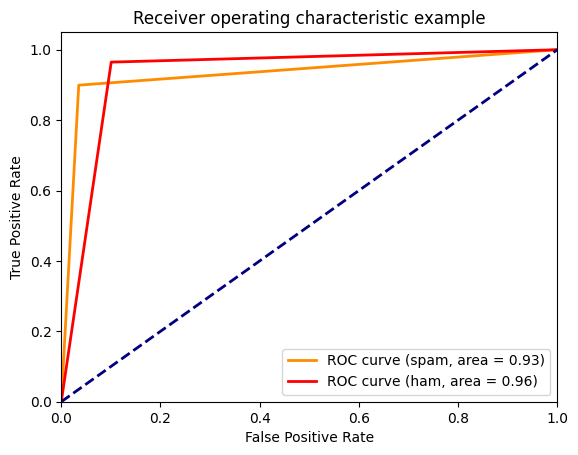

In [30]:
from sklearn.metrics import roc_curve, auc
y_pred_proba = model.predict_proba(np.asarray(X_test.todense()))
fpr_spam, tpr_spam, thresholds = roc_curve(y_test, y_pred_proba[:, 1], pos_label=1)
roc_auc_spam = auc(fpr_spam, tpr_spam)
fpr_ham, tpr_ham, thresholds = roc_curve(y_test, y_pred_proba[:, 0], pos_label=0)
roc_auc_ham = auc(fpr_spam, tpr_ham)

import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(fpr_spam, tpr_spam, color='darkorange',
         lw=lw, label='ROC curve (spam, area = %0.2f)' % roc_auc_spam)
plt.plot(fpr_ham, tpr_ham, color='red',
         lw=lw, label='ROC curve (ham, area = %0.2f)' % roc_auc_ham)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Alternative: HashingVectorizer
Với các bộ dữ liệu lớn dẫn đến vocab cao, việc sử dụng CountVectorizer thông thường để lưu trữ dữ liệu vector hóa trở nên tốn tài nguyên; Một phương pháp chúng ta có thể cân nhắc là sử dụng HashingVectorizer. Thay vì CountVectorizer biến mỗi từ/ngram thành 1 id tương ứng, nhiều từ của HashingVectorizer sẽ có thể cho nhiều từ vào 1 id xác định bằng mảng băm.

Lựa chọn giữa 2 phương pháp là tradeoff giữa tài nguyên lưu trữ như RAM và chất lượng mô hình. Thay đổi giá trị n_features và cân nhắc tradeoff ở bao nhiêu là phù hợp để mô hình không bị kém đi quá nhiều.

**Học viên tìm và thử nghiệm giá trị `hash_size`, sao cho mô hình không chênh lệch quá lớn với kết quả gốc:**

In [31]:
from sklearn.feature_extraction.text import TfidfTransformer, HashingVectorizer

hash_size = 2**10
hashed_data = HashingVectorizer(n_features=hash_size, ngram_range=(1, 3), stop_words='english').fit_transform(spam_data["text"])
hashed_matrix_data = TfidfTransformer().fit_transform(hashed_data)

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score

X_htrain, X_htest, y_htrain, y_htest = train_test_split(hashed_matrix_data, y_data, test_size=0.1, random_state=0)
model = GaussianNB()
model.fit(np.asarray(X_htrain.todense()), y_htrain)
y_hpred = model.predict(np.asarray(X_htest.todense()))
print("[HashedVectorizer] F1 Score: {:.4f}; Accuracy Score: {:.4f}".format(f1_score(y_hpred, y_htest), accuracy_score(y_hpred, y_htest)))

[HashedVectorizer] F1 Score: 0.7809; Accuracy Score: 0.8494
